In [1]:
%load_ext autoreload
%autoreload 2
from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.linear_model import ElasticNetCV, LinearRegression, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_X_y
from sklearn.utils.validation import _check_sample_weight
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm
from collections import defaultdict
import dvu
import pandas as pd
import matplotlib.pyplot as plt
import json
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import Normalize
import joblib
import viz
from interpret import show

import imodels
from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.base import RegressorMixin, ClassifierMixin
from imodels.algebraic.gam_multitask import MultiTaskGAMRegressor

# Fit some simple GAMs

In [14]:
d = defaultdict(list)
for dset in ['bike_sharing', 'california_housing', 'diabetes_regr', 'heart']:
    for use_single_task_with_reweighting in [False, True]:
        X, y, feature_names = imodels.get_clean_dataset(dset)
        X = StandardScaler().fit_transform(X)
        y = StandardScaler().fit_transform(y.reshape(-1, 1)).ravel()
        X, X_test, y_train, y_test = train_test_split(
            X, y, random_state=42, test_size=0.25)
        ebm_kwargs = dict(
            random_state=42,
            n_jobs=-2,
        )

        gam = MultiTaskGAMRegressor(
            multitask=use_single_task_with_reweighting,
            interactions=False,
            use_single_task_with_reweighting=use_single_task_with_reweighting,
            ebm_kwargs=ebm_kwargs)

        np.random.seed(42)
        gam.fit(X, y_train)
        d['dset'].append(dset)
        d['use_single_task_with_reweighting'].append(
            use_single_task_with_reweighting)
        d['test_corr'].append(np.corrcoef(y_test, gam.predict(X_test))[0, 1])
        d['test_r2'].append(gam.score(X_test, y_test))
        d['train_corr'].append(np.corrcoef(y_train, gam.predict(X))[0, 1])
        d['train_r2'].append(gam.score(X, y_train))
        if hasattr(gam, 'lin_model') and hasattr(gam.lin_model, 'coef_'):
            d['coef'].append(gam.lin_model.coef_)
        else:
            d['coef'].append([])
        # print(pd.DataFrame(d))
joblib.dump(pd.DataFrame(d), '../figs/use_single_task_reweighting_results.pkl')
# print('test_corr', np.corrcoef(
#     y_test, gam.predict(X_test))[0, 1].round(3))
# print('test r2', gam.score(X_test, y_test).round(3))
# joblib.dump(
# gam, f'../figs/{dset}_gam_fit_target_curves={fit_target_curves}.pkl')

fetching 42712 from openml
fetching 42712 from openml
fetching california_housing from sklearn
fetching california_housing from sklearn
fetching diabetes from sklearn
fetching diabetes from sklearn
fetching heart from imodels
fetching heart from imodels


['../figs/use_single_task_reweighting_results.pkl']

In [16]:
df = pd.DataFrame(d)

In [17]:
df

,dset,use_single_task_with_reweighting,test_corr,test_r2,train_corr,train_r2,coef
0,bike_sharing,False,0.836119,0.698784,0.838483,0.702995,[]
1,bike_sharing,True,0.835990,0.698622,0.838530,0.703132,"[1.0115957781715603, 0.9998486871376286, 1.043..."
2,california_housing,False,0.875212,0.765922,0.890239,0.792252,[]
3,california_housing,True,0.875343,0.766119,0.890845,0.793606,"[0.9717133640775018, 0.9195439381279513, 1.139..."
4,diabetes_regr,False,0.708423,0.501829,0.804974,0.634255,[]
5,diabetes_regr,True,0.675224,0.438762,0.826003,0.682211,"[1.708178546543123, 1.2967127570814825, 1.2179..."
6,heart,False,0.749362,0.531248,0.771149,0.585529,[]
7,heart,True,0.708244,0.490215,0.783404,0.611341,"[1.6572355194861403, 1.1010378575369875, 1.446..."


In [20]:
df.pivot_table(index='dset', values='test_corr',
               columns='use_single_task_with_reweighting').round(3)

use_single_task_with_reweighting,False,True
dset,,
bike_sharing,0.836,0.836
california_housing,0.875,0.875
diabetes_regr,0.708,0.675
heart,0.749,0.708


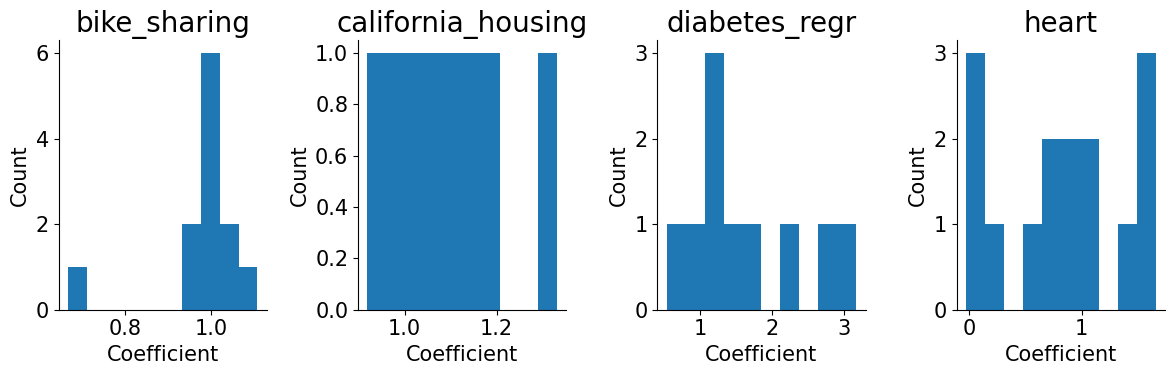

In [25]:
df1 = df[df['use_single_task_with_reweighting'] == True]
plt.figure(figsize=(12, 4))
for i in range(len(df1)):
    plt.subplot(1, len(df1), i+1)
    plt.hist(df1['coef'].iloc[i])
    plt.title(df1['dset'].iloc[i])
    plt.xlabel('Coefficient')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()